# Analyse

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import correlate

In [15]:
# ursprüngliches df der betrachteten Koeffizienten
df_important_coef = pd.read_csv('../data/prediction/df_important_coef.csv')

df_orig_level = df_important_coef['waterlevel(m)']
df_orig_temp = df_important_coef['temperature_mean(degC)']
df_orig_vol = df_important_coef['discharge_vol(m3/s)']
df_orig_rain = df_important_coef['precipitation(mm/d)']

# Daten die im 2_modellierung.ipynb mit seasonal_decompose erstellt wurden
df_vol_comp = pd.read_csv('../data/prediction/prediction_discharge_vol.csv')
df_temp_comp = pd.read_csv('../data/prediction/prediction_temperature_mean.csv')
df_level_comp = pd.read_csv('../data/prediction/prediction_waterlevel.csv')
df_rain_comp = pd.read_csv('../data/prediction/prediction_rain.csv')

## Korrelationsanalyse 

In [16]:
## Funktionen
def p_acf_seasonal_decompose(decomp_result, original_data=None, title_prefix=''):
    """
    Visualisiert Residuen und Komponenten einer seasonal_decompose Zerlegung.

    Parameter:
    - decomp_result: Ergebnis von seasonal_decompose (mit Attributen resid, seasonal, trend).
    - original_data: Original-Zeitreihe als Pandas Series (optional), für Gesamtgrafik.
    - title_prefix: String zur Titel-Anpassung der Plots (optional).

    Beispiel:
    analyze_seasonal_decompose(zr, original_data=ts, title_prefix='Meine Zeitreihe')
    """

    resid = decomp_result.resid.dropna()
    seasonal = decomp_result.seasonal.dropna()
    trend = decomp_result.trend.dropna()

    # 1. Residuen analysieren
    print('Residuen')
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    resid.plot(title=f'{title_prefix} Residuen', ax=axs[0])
    plot_acf(resid, title=f'ACF {title_prefix} Residuen', ax=axs[1])
    plot_pacf(resid, title=f'PACF {title_prefix} Residuen', ax=axs[2])
    plt.show()

    # 2. Beitrag der Komponenten
    print('Vergleich mit Komponenten')
    fig, axs = plt.subplots(3, 3, figsize=(16, 16))

    seasonal.plot(title=f'{title_prefix} Saison', ax=axs[0, 0])
    plot_acf(seasonal, title=f'ACF {title_prefix} Saison', ax=axs[0, 1])
    plot_pacf(seasonal, title=f'PACF {title_prefix} Saison', ax=axs[0, 2])

    trend.plot(title=f'{title_prefix} Trend', ax=axs[1, 0])
    plot_acf(trend, title=f'ACF {title_prefix} Trend', ax=axs[1, 1])
    plot_pacf(trend, title=f'PACF {title_prefix} Trend', ax=axs[1, 2])

    if original_data is not None:
        original_data.plot(title=f'{title_prefix} Gesamt', ax=axs[2, 0])
        plot_acf(original_data.dropna(), title=f'ACF {title_prefix} Gesamt', ax=axs[2, 1])
        plot_pacf(original_data.dropna(), title=f'PACF {title_prefix} Gesamt', ax=axs[2, 2])
    else:
        for ax in axs[2]:
            ax.axis('off')

    plt.show()


### ACF/PACF

ACF/PACF der stationären Residuen -->  Lag definieren


#### Erwartung
In den ACF- und PACF-Plots einer Zeitreihe betrachten wir die Autokorrelation (ACF) und die partielle Autokorrelation (PACF), um die zeitliche Struktur und Zusammenhänge verschiedener Komponenten (Saison, Trend, Residuen, Gesamt) zu analysieren. Ziel ist es, Muster wie Saisonalität, Trendverhalten und Zufallskomponenten zu erkennen. Im Folgenden sind die Beobachtungen für die Variablen "waterlevel(m)", "temperature_mean(degC)" und "discharge_vol(m3/s)" anhand deiner bereitgestellten Plots zusammengefasst:

- **ACF (Autokorrelationsfunktion):** Zeigt, wie stark Werte im Zeitverlauf miteinander korreliert sind. Typisch bei saisonalen Reihen sind periodische Peaks. Persistente hohe Werte über viele Lags deuten einen Trend an, schnelle Abnahme oder periodische Muster auf Saisonalität.

- **PACF (Partielle Autokorrelationsfunktion):** Zeigt den Einfluss eines Werts auf andere, bereinigt um Zwischenwerte. Ein signifikanter Peak bei niedrigen Lags spricht für autoregressive Prozesse – etwa für die Wahl des AR-Parameters in Modellen wie ARIMA.


ACF / PACF für discharge_vol(m3/s):

Residuen


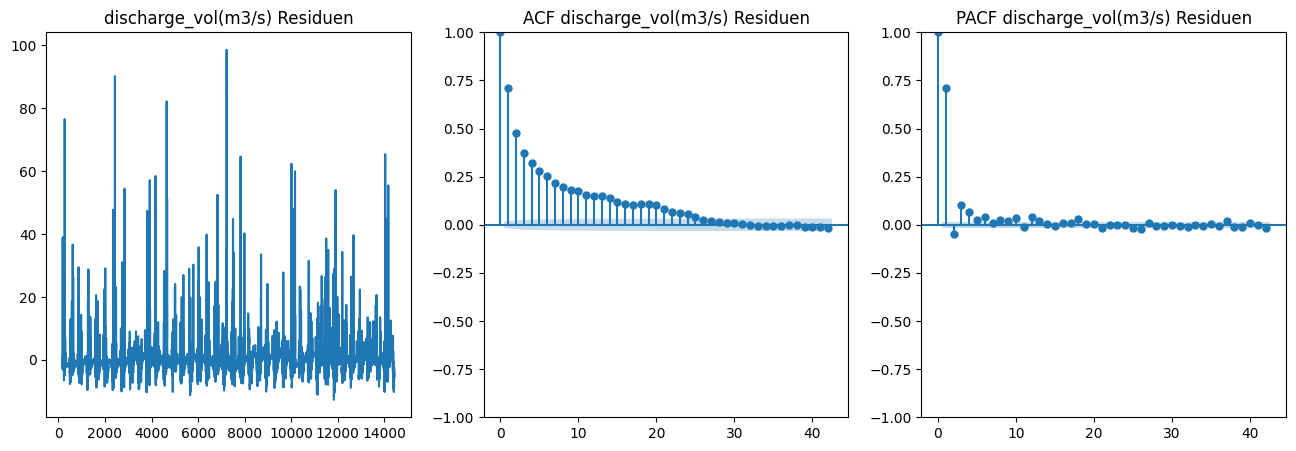

Vergleich mit Komponenten


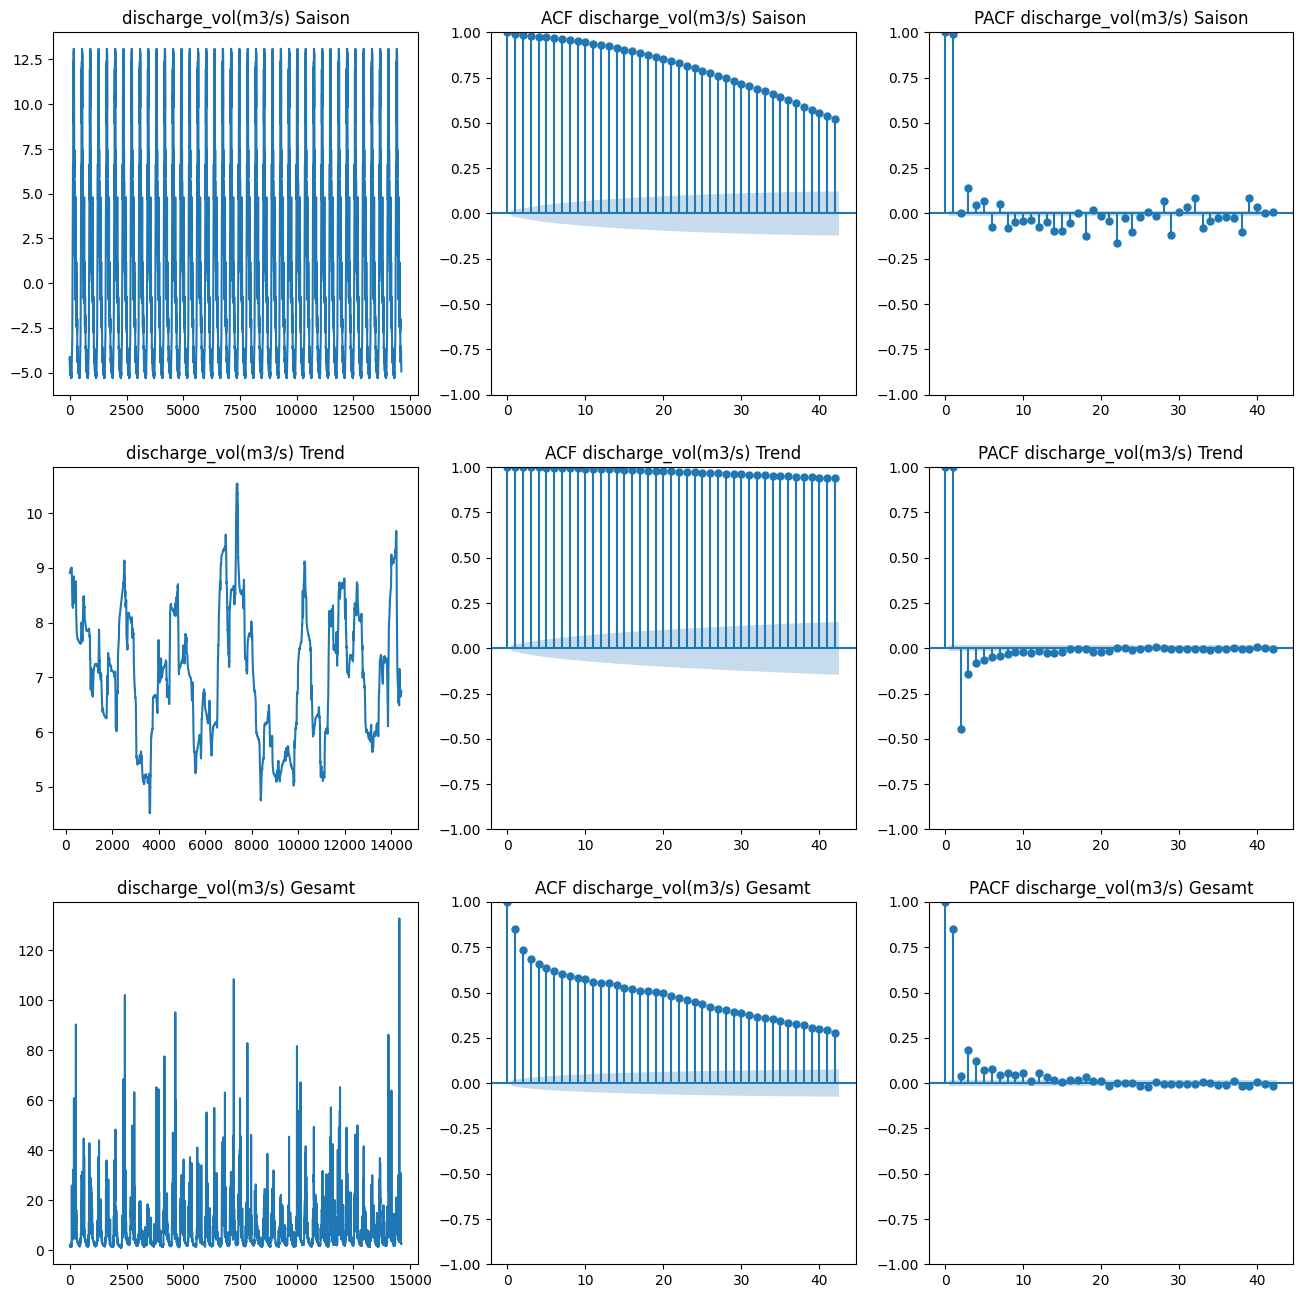

In [17]:
#Betrachtung für discharge_vol(m3/s)

print('\nACF / PACF für discharge_vol(m3/s):\n')
p_acf_seasonal_decompose(df_vol_comp, df_orig_vol, 'discharge_vol(m3/s)')

**discharge_vol(m3/s)**
- *Saison:* Hier ist Saisonalität sehr deutlich: periodische Schwankungen in der Zeitreihe, langsamer ACF-Abfall, PACF nur bei Lag 1 und 2 auffällig.
- *Trend:* Moderate langfristige Bewegungen, ACF bleibt lange hoch, PACF v.a. bei wenigen Lags bedeutsam.
- *Gesamt:* Mischbild aus Saisonalität und Trend, ACF moderat abfallend, PACF initial hoch, dann flach.
- *Residuen:* Vor allem Kurzzeitstruktur, schneller ACF-Abfall, PACF flacht rasch ab, kein klarer Trend mehr erkennbar.

*Erkenntnis*:
- ACF: Signifikante Peaks bis etwa Lag 5, danach flachen die Werte deutlich ab.​
- PACF: Nur Lag 1 und Lag 2 deutlich, danach ist alles unwichtig.​
- Passender Lag für Modellierung: Lag 5 (ARIMA(0,0,5) ist passend)


ACF / PACF für waterlevel(m):

Residuen


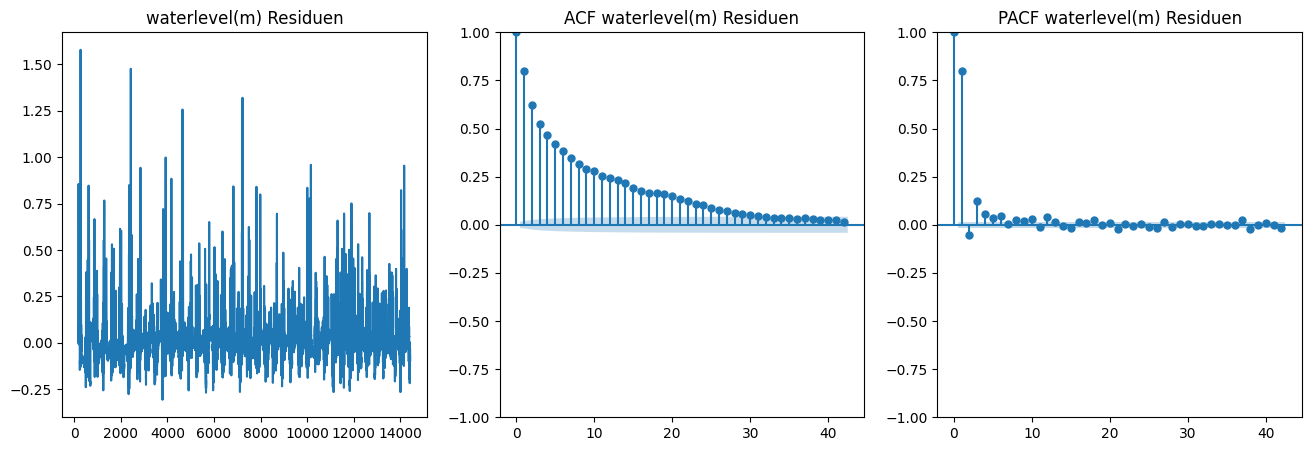

Vergleich mit Komponenten


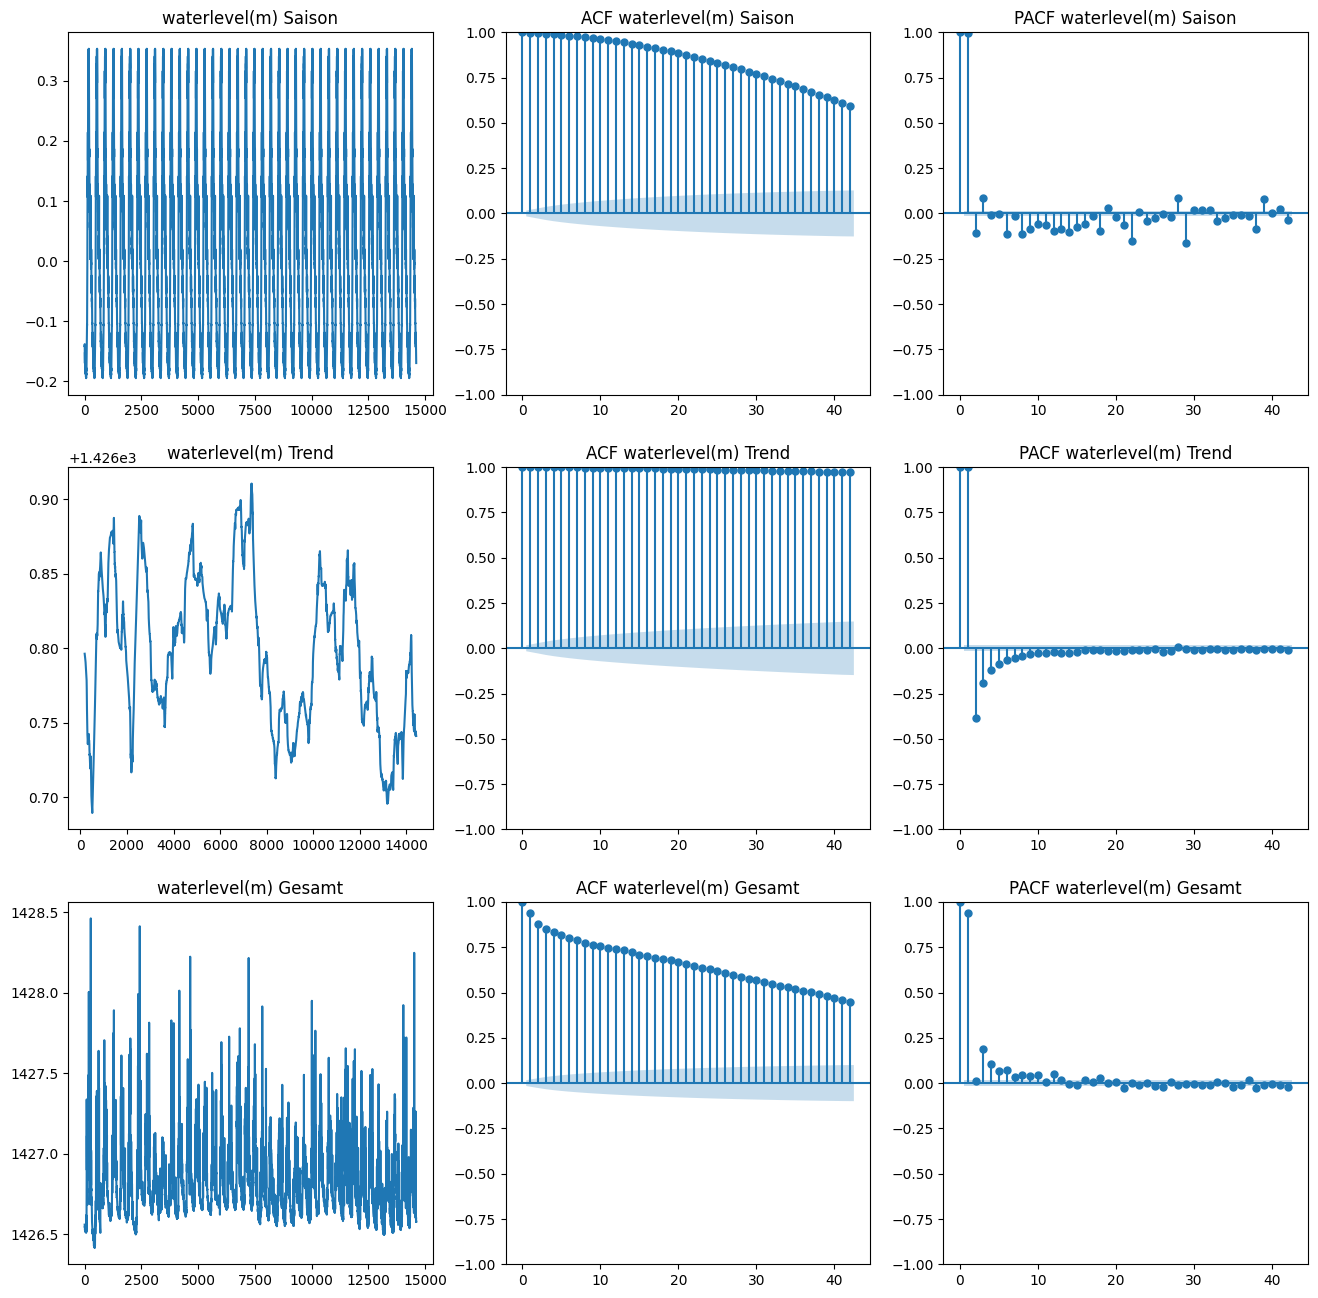

In [18]:
#Betrachtung für waterlevel(m)

print('\nACF / PACF für waterlevel(m):\n')
p_acf_seasonal_decompose(df_level_comp, df_orig_level, 'waterlevel(m)')

**waterlevel(m)**
- *Saison:* Die Zeitreihe zeigt stark ausgeprägte periodische Muster, ACF nimmt langsam ab, PACF hat nur die ersten Lags signifikant. Das spricht klar für regelmäßige Saisonalität.
- *Trend:* Die Werte bewegen sich langfristig, ACF bleibt über viele Lags hoch, PACF ist nur am Anfang relevant. Das zeigt einen ausgeprägten Trend ohne deutliche kurzfristige Einflüsse.
- *Gesamt:* Die Gesamtgrafik vereint beide Effekte. ACF nimmt mittelmässig ab (Saisonalität & Trend), PACF ist wie beim Trend.
- *Residuen:* Eher schnelle Abnahme in der ACF, kein dominierender Lag im PACF – hier dominiert der Zufall, wenig Struktur vorhanden.


*Erkenntniss*
- ACF: Die ersten 4-5 Lags sind noch erhöht, danach kaum noch Struktur.​
- PACF: Ein deutlicher Ausschlag bei Lag 1, sehr schwach noch Lag 2 bis maximal Lag 3.​
- Passender Lag für Modellierung: Lag 5 (MA(5) als Obergrenze ist sinnvoll)


ACF / PACF für temperature_mean(degC):

Residuen


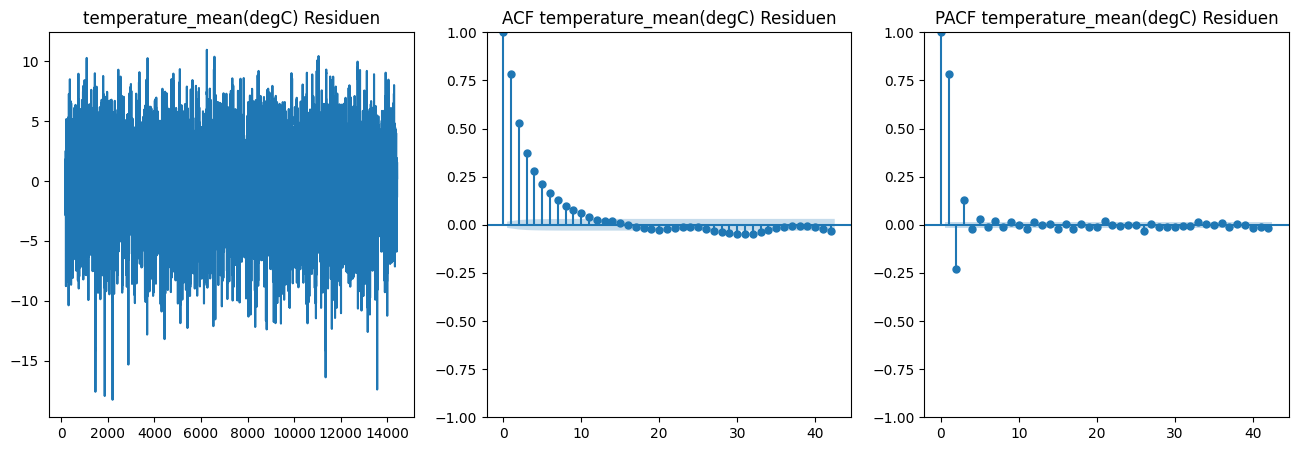

Vergleich mit Komponenten


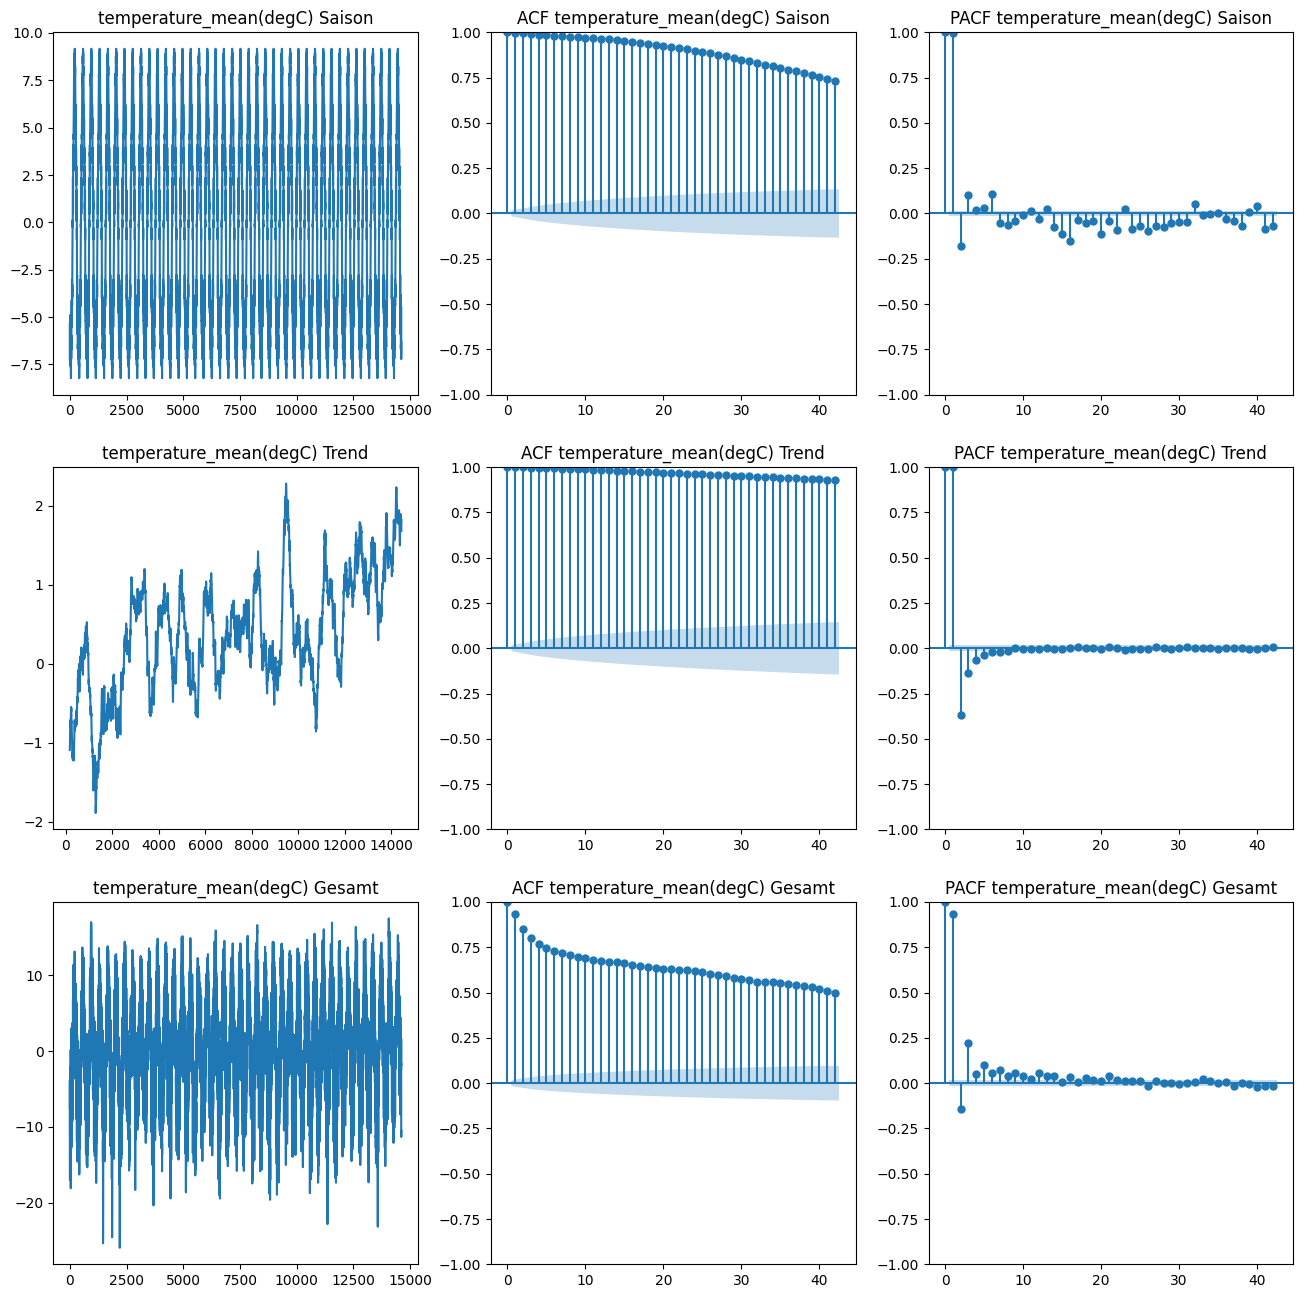

In [19]:
#Betrachtung für temperature_mean(degC)

print('\nACF / PACF für temperature_mean(degC):\n')
p_acf_seasonal_decompose(df_temp_comp, df_orig_temp, 'temperature_mean(degC)')

**temperature_mean(degC)**
- *Saison:* Deutliche periodische Ausschläge und langsamer Abfall der ACF, PACF zeigt nur Anfangslags. Hier dominiert eine sehr starke Saisonalität.
- *Trend:* Langfristig ansteigender Verlauf, ACF bleibt hoch, PACF flacht nach wenigen Lags ab, typisch für Trends.
- *Gesamt:* Kombinierte Muster wie oben: beides ist erkennbar, ACF fällt langsamer, PACF nur am Anfang bedeutsam.
- *Residuen:* Stärkere zufällige Schwankungen, ACF nimmt schneller ab, PACF flacht rasch ab, kein starker Trend oder Saisonalität mehr.

*Erkenntniss*
- ACF: Signifikante Autokorrelation bis etwa Lag 4 oder 5; danach fallen die Werte in den Zufallsbereich.​
- PACF: Lag 1 und schwach Lag 2, alles Weitere unauffällig.​
- Passender Lag für Modellierung: Lag 5 (MA(5) deckt alle relevanten Abhängigkeiten ab)

### Kreuzkorrelation 
Kreuzkorrelation zwischen Wasserstand und den anderen drei Variablen um Verzögerungen zu identifizieren.




Kreuzkorrelation Residuen Level und Temp
Anzahl gültiger Beobachtungen: 14246


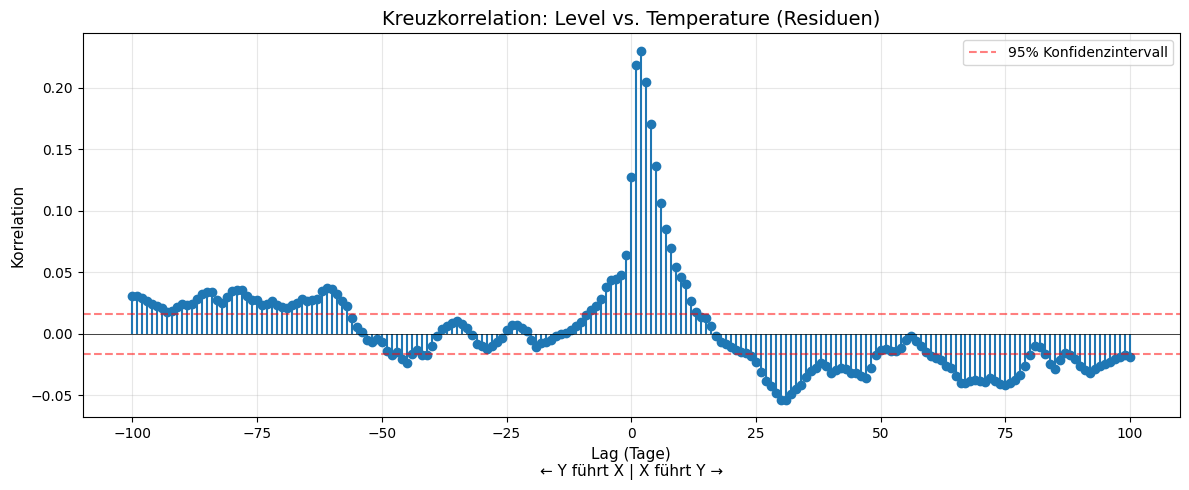


Top 5 signifikante Korrelationen:
  Lag    2: +0.2302 (X führt Y um 2 Tage)
  Lag    1: +0.2187 (X führt Y um 1 Tage)
  Lag    3: +0.2049 (X führt Y um 3 Tage)
  Lag    4: +0.1706 (X führt Y um 4 Tage)
  Lag    5: +0.1365 (X führt Y um 5 Tage)

Stärkste Korrelation bei Lag 2: 0.2302

Kreuzkorrelation Residuen Level und Rain
Anzahl gültiger Beobachtungen: 14246


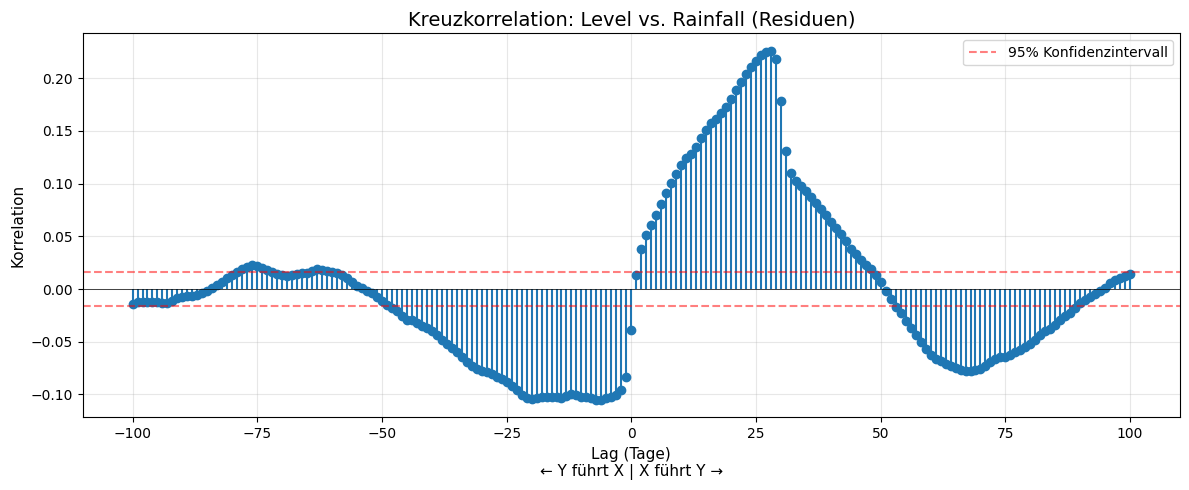


Top 5 signifikante Korrelationen:
  Lag   28: +0.2259 (X führt Y um 28 Tage)
  Lag   27: +0.2249 (X führt Y um 27 Tage)
  Lag   26: +0.2216 (X führt Y um 26 Tage)
  Lag   29: +0.2179 (X führt Y um 29 Tage)
  Lag   25: +0.2164 (X führt Y um 25 Tage)

Stärkste Korrelation bei Lag 28: 0.2259

Kreuzkorrelation Residuen Level und Vol
Anzahl gültiger Beobachtungen: 14246


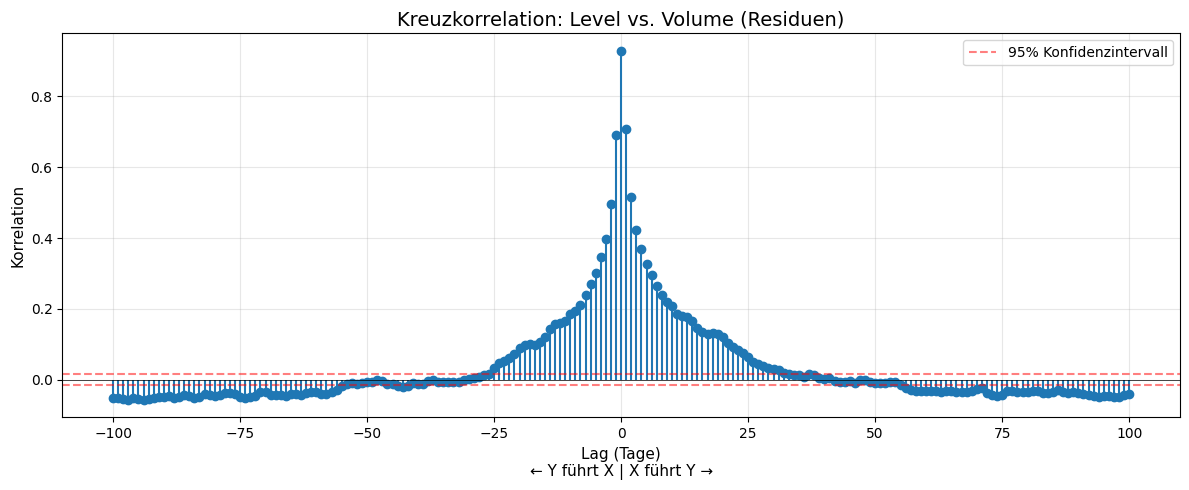


Top 5 signifikante Korrelationen:
  Lag    0: +0.9290 (gleichzeitig)
  Lag    1: +0.7081 (X führt Y um 1 Tage)
  Lag   -1: +0.6899 (Y führt X um 1 Tage)
  Lag    2: +0.5173 (X führt Y um 2 Tage)
  Lag   -2: +0.4953 (Y führt X um 2 Tage)

Stärkste Korrelation bei Lag 0: 0.9290


In [29]:
from statsmodels.tsa.stattools import ccf

res_level = df_level_comp['resid']
res_temp = df_temp_comp['resid']
res_rain = df_rain_comp['resid']
res_vol = df_vol_comp['resid']

from statsmodels.tsa.stattools import ccf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cross_correlation(x, y, max_lags=100, title='Cross-Korrelation'):
    """
    Berechnet und plottet Kreuzkorrelation zwischen zwei Zeitreihen.
    
    Parameters:
    -----------
    x, y : pd.Series oder np.array
        Die beiden Zeitreihen
    max_lags : int
        Maximale Anzahl Lags (in beide Richtungen)
    title : str
        Titel des Plots
    """
    
    # 1) Gemeinsamen Index finden und NaN entfernen
    if isinstance(x, pd.Series) and isinstance(y, pd.Series):
        df = pd.DataFrame({'x': x, 'y': y}).dropna()
        x_clean = df['x'].values
        y_clean = df['y'].values
        print(f"Anzahl gültiger Beobachtungen: {len(x_clean)}")
    else:
        # Für numpy arrays
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        print(f"Anzahl gültiger Beobachtungen: {len(x_clean)}")
    
    if len(x_clean) < 10:
        print("WARNUNG: Zu wenige Datenpunkte für aussagekräftige Korrelation!")
        return None, None
    
    # 2) Begrenze max_lags auf sinnvolle Größe
    max_lags = min(max_lags, len(x_clean) // 4)
    
    # 3) Berechne CCF (gibt nur positive Lags zurück)
    ccf_values = ccf(x_clean, y_clean, adjusted=False)
    
    # 4) Erstelle symmetrische Lags (negativ und positiv)
    # Negative Lags: y führt x
    # Positive Lags: x führt y
    n_lags = min(len(ccf_values), max_lags + 1)
    lags_positive = np.arange(0, n_lags)
    ccf_positive = ccf_values[:n_lags]
    
    # Für negative Lags: vertausche x und y
    ccf_negative_full = ccf(y_clean, x_clean, adjusted=False)
    ccf_negative = ccf_negative_full[1:n_lags][::-1]  # Ohne Lag 0, umgedreht
    
    # Kombiniere
    lags = np.concatenate([-lags_positive[1:][::-1], lags_positive])
    correlations = np.concatenate([ccf_negative, ccf_positive])
    
    # 5) Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.stem(lags, correlations, basefmt=' ')
    
    # Konfidenzintervall (95%)
    conf_level = 1.96 / np.sqrt(len(x_clean))
    ax.axhline(y=conf_level, color='r', linestyle='--', alpha=0.5, label='95% Konfidenzintervall')
    ax.axhline(y=-conf_level, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Lag (Tage)\n← Y führt X | X führt Y →", fontsize=11)
    ax.set_ylabel("Korrelation", fontsize=11)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # 6) Finde signifikante Peaks
    significant = np.abs(correlations) > conf_level
    sig_lags = lags[significant]
    sig_corrs = correlations[significant]
    
    if len(sig_lags) > 0:
        # Sortiere nach absoluter Korrelation
        sorted_idx = np.argsort(np.abs(sig_corrs))[::-1]
        print("\nTop 5 signifikante Korrelationen:")
        for i in sorted_idx[:5]:
            lag = sig_lags[i]
            corr = sig_corrs[i]
            if lag < 0:
                print(f"  Lag {lag:4d}: {corr:+.4f} (Y führt X um {abs(lag)} Tage)")
            elif lag > 0:
                print(f"  Lag {lag:4d}: {corr:+.4f} (X führt Y um {lag} Tage)")
            else:
                print(f"  Lag {lag:4d}: {corr:+.4f} (gleichzeitig)")
    else:
        print("\nKeine signifikanten Korrelationen gefunden.")
    
    # Maximum in beide Richtungen
    max_idx = np.argmax(np.abs(correlations))
    max_lag = lags[max_idx]
    max_corr = correlations[max_idx]
    print(f"\nStärkste Korrelation bei Lag {max_lag}: {max_corr:.4f}")
    
    return lags, correlations


# Anwendung auf deine Residuen
print('='*60)
print('Kreuzkorrelation Residuen Level und Temp')
print('='*60)
lags1, corr1 = plot_cross_correlation(
    res_level, res_temp, 
    max_lags=100,
    title='Kreuzkorrelation: Level vs. Temperature (Residuen)'
)

print('\n' + '='*60)
print('Kreuzkorrelation Residuen Level und Rain')
print('='*60)
lags2, corr2 = plot_cross_correlation(
    res_level, res_rain, 
    max_lags=100,
    title='Kreuzkorrelation: Level vs. Rainfall (Residuen)'
)

print('\n' + '='*60)
print('Kreuzkorrelation Residuen Level und Vol')
print('='*60)
lags3, corr3 = plot_cross_correlation(
    res_level, res_vol, 
    max_lags=100,
    title='Kreuzkorrelation: Level vs. Volume (Residuen)'
)


## Stochastische Modellierung



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def analyze_component_residuen(decomp_result, title_prefix='', model_param=(0, 0, 5)):
    """
    Plot Korrelogramme und fitte ein MA(5)-Modell auf die Residuen der seasonal_decompose-Komponente.

    Parameter:
    - decomp_result: Ein DataFrame oder Objekt mit Attribut 'resid' für die Residuen, wie von seasonal_decompose.
    - title_prefix: Titel-Ergänzung für die Plots.
    """

    resid = decomp_result['resid'].dropna()

    # 1a. Korrelogramme
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    resid.plot(title=f'{title_prefix} Residuen', ax=axs[0])
    plot_acf(resid, title=f'ACF {title_prefix} Residuen', ax=axs[1])
    plot_pacf(resid, title=f'PACF {title_prefix} Residuen', ax=axs[2])
    plt.show()

    # 1b. Moving-Average-(ARIMA-)Modell
    Nied_Modell = ARIMA(resid, order=model_param)  
    Nied_resid_fit = Nied_Modell.fit()
    print(Nied_resid_fit.summary())
    print("\n")


### ARIMA 
für univariate Prognose


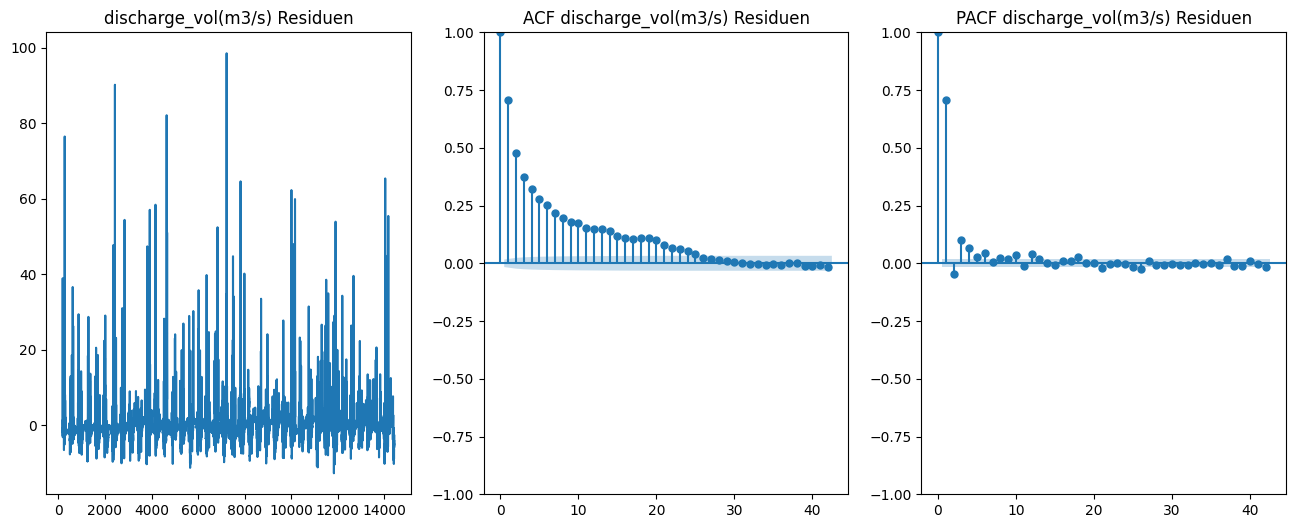

c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                14246
Model:                 ARIMA(0, 0, 5)   Log Likelihood              -37998.782
Date:                Fri, 21 Nov 2025   AIC                          76011.563
Time:                        13:49:27   BIC                          76064.513
Sample:                             0   HQIC                         76029.176
                              - 14246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.128      0.010      0.992      -0.249       0.252
ma.L1          0.7514      0.002    388.979      0.000       0.748       0.755
ma.L2          0.4342      0.003    146.963      0.0

In [ ]:
analyze_component_residuen(df_vol_comp, 'discharge_vol(m3/s)')

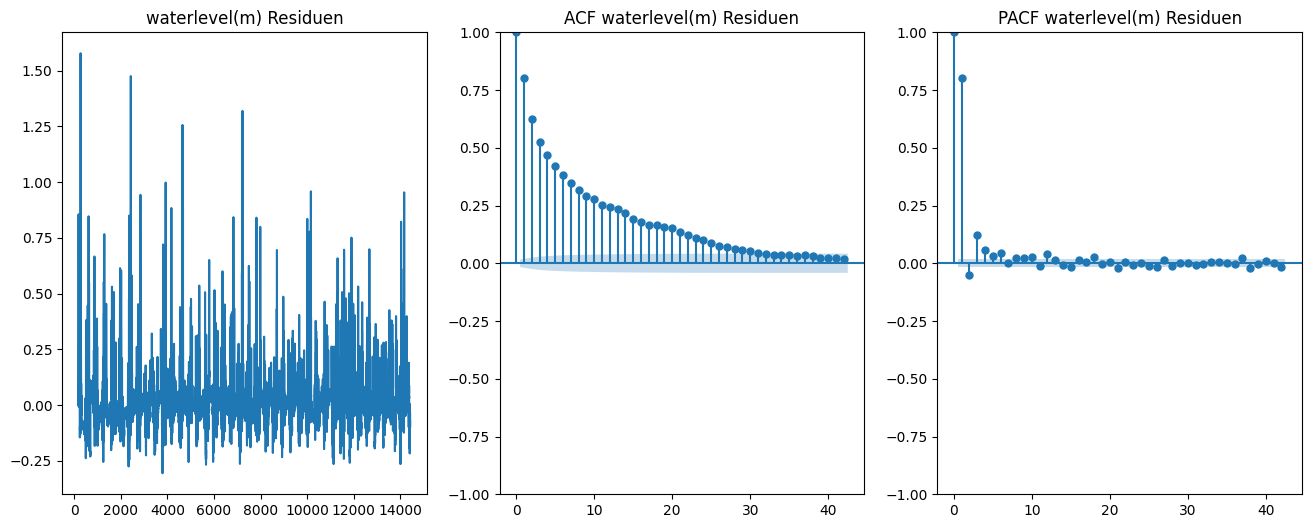

c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                14246
Model:                 ARIMA(0, 0, 5)   Log Likelihood               18409.710
Date:                Fri, 21 Nov 2025   AIC                         -36805.420
Time:                        13:40:32   BIC                         -36752.471
Sample:                             0   HQIC                        -36787.808
                              - 14246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.099e-05      0.003     -0.008      0.994      -0.005       0.005
ma.L1          0.8726      0.003    318.642      0.000       0.867       0.878
ma.L2          0.5827      0.004    144.673      0.0

In [ ]:
analyze_component_residuen(df_level_comp, 'waterlevel(m)')

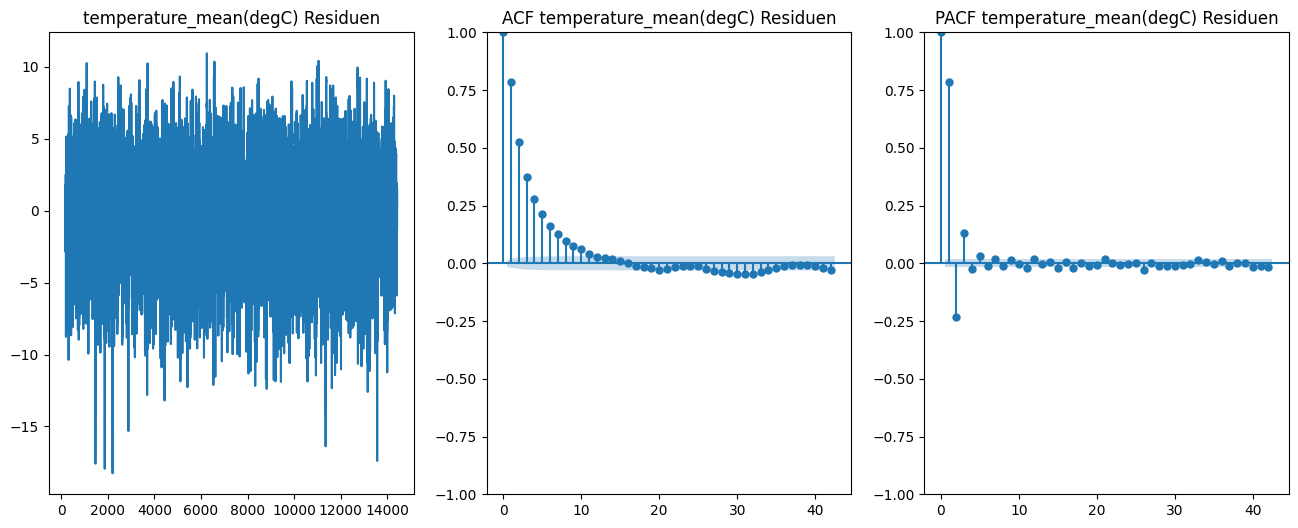

c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Sandra\Documents\GitHub\spz\spz_Wasserstand_analyse\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                14246
Model:                 ARIMA(0, 0, 5)   Log Likelihood              -31801.846
Date:                Fri, 21 Nov 2025   AIC                          63617.692
Time:                        13:40:36   BIC                          63670.642
Sample:                             0   HQIC                         63635.304
                              - 14246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.067     -0.081      0.935      -0.136       0.125
ma.L1          1.0023      0.008    132.011      0.000       0.987       1.017
ma.L2          0.6240      0.011     56.269      0.0

In [ ]:
analyze_component_residuen(df_temp_comp, 'temperature_mean(degC)')

### VAR 
für multivariate Analyse

### Eventuell ARIMAX mit Temperatur als exogene Variable